### Load Packages

In [1]:
# primary EDA code
import pandas as pd
import numpy as np
import os

# packages for plots
import matplotlib.pyplot as plt
import seaborn as sns

# warning ignore
import warnings
warnings.filterwarnings("ignore")

# packages for ML
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

# packages for cross-validation
from sklearn.model_selection import StratifiedKFold

### Load Data & Filter NA/ Duplicate Records

In [0]:
# Read files from Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
file_path = '../data/' 

In [3]:
def data_import(folder_path, stock_list, signal_type = "buy", number_of_days = 3):
    df_gp = pd.DataFrame()
    print()
    print("Loading", signal_type, "singal data:")
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
          
            # Stock ID is assume to be 4 digits
            pos = max(filename.find('S'), filename.find('B'))
            if pos == -1:
              pos = 45
            stock = str(filename[0:pos]).replace('1','')
            
            print(stock, " ", end = '')
            try:
                temp_df = pd.read_csv(os.path.join(folder_path, filename), delimiter= '\s+', header = None)
                
                # Number of Days Adjustment
                if number_of_days == 9:
                  temp_df = pd.concat([temp_df.iloc[:, 0:41], temp_df.iloc[:, 118:159], temp_df.iloc[:, 236:277], temp_df.iloc[:, 354]],axis=1)
                  
                # Cut first 20 Records
                temp_df = temp_df.iloc[21:,:]
                temp_df = temp_df.reset_index(drop=True)
                
                # Buy/Sell Distinguished
                temp_df.rename(columns={123:'rtn'}, inplace=True)
                if signal_type == "buy":
                  temp_df = pd.concat([pd.Series([1] * temp_df.shape[0], name = 'signal_type'), temp_df], axis=1)
                else:
                  temp_df = pd.concat([pd.Series([0] * temp_df.shape[0], name = 'signal_type'), temp_df], axis=1)
                  temp_df['rtn'] = -temp_df['rtn']
                  
                # Add stock name
                if stock not in stock_list:
                  stock_list.append(stock)
                temp_df = pd.concat([pd.Series([stock_list.index(stock)] * temp_df.shape[0], name = 'stock_name'), temp_df], axis=1)
                
                # Merge into the Output Database
                df_gp = pd.concat([df_gp, temp_df])
                continue
                
            except:
                print('The following file cannot be read: ' + folder_path + filename)
        else:
            continue
    
    # Set all columns to numerics
    for col in df_gp.columns:
      if col != 'stock_name':
        df_gp[col] = pd.to_numeric(df_gp[col],errors='coerce')
    
    # Rename the columns 
    osc_headers = []
    stk_headers = []
    macd_headers = []
    for i in range(41):
        osc_headers.append('osc' + str(i))
        stk_headers.append('stk' + str(i))
        macd_headers.append('macd' + str(i))
    df_gp.columns = ['stock_name'] + ['signal_type'] + osc_headers + stk_headers + macd_headers + ['rtn']
    
    # Reset index
    df_gp = df_gp.reset_index(drop=True)

    return df_gp, stock_list

In [4]:
stock_list = []

# Import Buy & Sell Data
#df_buy9_gp, stock_list = data_import(file_path + '9days/', stock_list, signal_type = "buy", number_of_days = 9)
print()
df_buy_gp, stock_list = data_import(file_path + 'buy/', stock_list, signal_type = "buy")
print()
df_sell_gp, stock_list = data_import(file_path + 'sell/', stock_list, signal_type = "sell")

#df_combined = df_buy_gp
#df_combined = pd.concat([df_buy9_gp, df_buy_gp, df_sell_gp])
df_combined = pd.concat([df_buy_gp, df_sell_gp])

# Drop Duplicated Records
len_before = df_combined.shape[0]
df_combined = df_combined.drop_duplicates(subset = df_combined.columns[1:])
print()
print()
print("Duplicates dropped:", len_before - df_combined.shape[0])

# Drop Records with NaN
len_before = df_combined.shape[0]
df_combined = df_combined.dropna()
print()
print("Record(s) w/ NaN dropped:", len_before - df_combined.shape[0])
print()

# Only model OSC < 3 or up 
len_before = df_combined.shape[0]
df_combined = df_combined[(df_combined.osc0 < -0.5) | (df_combined.osc0 > 0.5)]
print("Small osc values dropped:", len_before - df_combined.shape[0])
print()

# Reset Index
df_combined = df_combined.reset_index(drop=True)

print("Remained Records:", df_combined.shape[0])
print()

# Check the balance of df_gp
print('Positive returns:', round(np.sum(df_combined.rtn > 0)/len(df_combined.rtn) * 100, 2), '%')
print('Zero returns:', round(np.sum(df_combined.rtn == 0)/len(df_combined.rtn) * 100, 2), '%')
print('Negative returns:', round(np.sum(df_combined.rtn < 0)/len(df_combined.rtn) * 100, 2), '%')

# Check stock movement
print()
print('Avg Stock Movement %', np.mean(df_combined.rtn))
print('Max Stock Movement %', np.max(df_combined.rtn))
print('Min Stock Movement %', np.min(df_combined.rtn))



Loading buy singal data:
acad  adbe  alny  amd  ati  bac  bidu  cenx  clf  crm  crus  csiq  db  gs  ions  itub  jec  jnpr  mas  meli  pru  pxd  ssys  teck  ufs  uri  

Loading sell singal data:
adbe  adsk  alny  amd  ati  bac  bidu  cenx  clf  crm  crus  csiq  db  fslr  gs  ions  itub  mas  meli  pru  pxd  ssys  teck  ufs  uri  

Duplicates dropped: 858

Record(s) w/ NaN dropped: 0

Small osc values dropped: 68569

Remained Records: 129043

Positive returns: 48.58 %
Zero returns: 3.28 %
Negative returns: 48.13 %

Avg Stock Movement % 0.04256402904458162
Max Stock Movement % 77.43
Min Stock Movement % -50.48


0.4091028702304956
2.2155704563678427
0.5549047317382194


[Text(0, 0.5, 'Count of Signals'), Text(0.5, 0, 'Investement Return')]

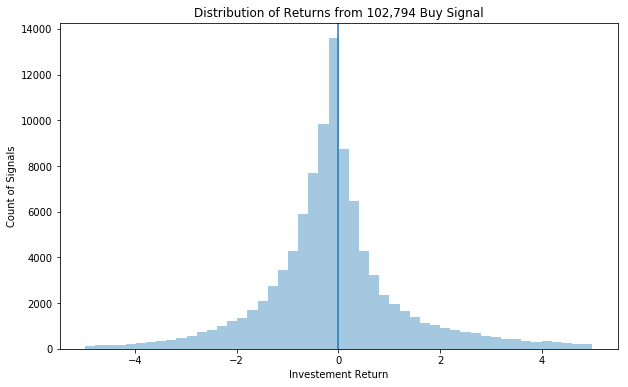

In [5]:
plt.figure(figsize=(10, 6))
plot_list = df_buy_gp.rtn
plot_list = plot_list[plot_list < 5]
plot_list = plot_list[plot_list > -5]
ax = sns.distplot(plot_list, bins = 50, kde = False)
ax.axvline(0, ls='-')
print(np.sum(df_buy_gp.rtn > 0)/len(df_buy_gp.rtn))
print(np.std(df_buy_gp.rtn))
print(np.sum(df_buy_gp.rtn < 0)/len(df_buy_gp.rtn))
plt.title('Distribution of Returns from 102,794 Buy Signal')
ax.set(xlabel='Investement Return', ylabel='Count of Signals')

### Split Data Into Parts

In [6]:
def data_organize(df_gp):
    try:
        stock_gp = df_gp.iloc[:, 0]
        signal_gp = df_gp.iloc[:, 1]
        osc_gp = df_gp.iloc[:, 2:43]
        stk_gp = df_gp.iloc[:, 43:84]
        macd_gp = df_gp.iloc[:, 84:125]
        rtn_gp = df_gp.iloc[:, 125]
        label_gp = rtn_gp
        
        # Return Censorship for control over UpRate, if we want both
        
        #label_gp = (rtn_gp > 0).map({False: -1, True: 1})
        #for i in range(len(label_gp)):
        #  if rtn_gp[i] > 5:
        #    label_gp[i] = 5
        #  elif rtn_gp[i] < -5:
        #    label_gp[i] = -5
        
        #print('5 :', round(np.sum(label_gp == 5)/len(label_gp) * 100, 2), '%')
        #print('+ :', round(np.sum(label_gp > 0)/len(label_gp) * 100, 2), '%')
        #print('0 :', round(np.sum(label_gp == 0)/len(label_gp) * 100, 2), '%')
        #print('-:', round(np.sum(label_gp < 0)/len(label_gp) * 100, 2), '%')
        #print('-5:', round(np.sum(label_gp == -5)/len(label_gp) * 100, 2), '%')
        
    except:
        print('Please check the dataframe index')

    return stock_gp, signal_gp, osc_gp, stk_gp, macd_gp, rtn_gp, label_gp

In [7]:
stock_gp, signal_gp, osc_gp, stk_gp, macd_gp, rtn_gp, label_gp = data_organize(df_combined)
#label_gp = rtn_gp

### Feature Engineering - add Additional Features

In [8]:
def smooth_generator(data, name = "osc"):
    smooth_list = []
    for i in range(data.shape[0]):
        smooth_list.append(np.var(np.diff(np.diff(data.iloc[i,:10])))/np.mean(np.absolute(data.iloc[i,:10])))
    smooth = pd.DataFrame(smooth_list, columns=["smooth_" + name])
    return smooth

def derivative(data, space = 1, name = "d", relative = False):
    dy = []
    for i in range(data.shape[0]):
        y = pd.Series(data.iloc[i,:])
        # Relative change
        if relative == True:
            y = y/(np.mean(np.abs(y)))
        temp_dy = list(np.diff(y))
        #temp_dy = list(np.gradient(y, space))
        dy.append(temp_dy)

    col_name = []
    for i in range(len(temp_dy)):
        col_name.append(name + str(i))

    deriv_df = pd.DataFrame(dy, columns=col_name)

    return deriv_df
  
def ratio(osc_gp, stk, macd):
    ratio_osc_stk0 = osc_gp.iloc[:, 0]/stk.iloc[:, 0]
    ratio_osc_stk1 = osc_gp.iloc[:, 1]/stk.iloc[:, 1]
    ratio_osc_stk2 = osc_gp.iloc[:, 2]/stk.iloc[:, 2]
    ratio_osc_stk3 = osc_gp.iloc[:, 3]/stk.iloc[:, 3]
    ratio_osc_stk4 = osc_gp.iloc[:, 4]/stk.iloc[:, 4]
    ratio_osc_stk = pd.concat([ratio_osc_stk0, ratio_osc_stk1, ratio_osc_stk2, ratio_osc_stk3, ratio_osc_stk4], axis=1)
    
    #ratio_osc_macd0 = osc_gp.iloc[:, 0]/macd.iloc[:, 0]
    #ratio_osc_macd1 = osc_gp.iloc[:, 1]/macd.iloc[:, 1]
    #ratio_osc_macd2 = osc_gp.iloc[:, 2]/macd.iloc[:, 2]
    #ratio_osc_macd3 = osc_gp.iloc[:, 3]/macd.iloc[:, 3]
    #ratio_osc_macd4 = osc_gp.iloc[:, 4]/macd.iloc[:, 4]
    #ratio_osc_macd = pd.concat([ratio_osc_macd0, ratio_osc_macd1, ratio_osc_macd2, ratio_osc_macd3, ratio_osc_macd4], axis=1)
    
    #ratio = pd.concat([pd.DataFrame(ratio_osc_stk.mean(axis = 1), columns=["ratio_osc_stk"]), pd.DataFrame(ratio_osc_macd.mean(axis = 1), columns=["ratio_osc_macd"])], axis=1)
    ratio = pd.DataFrame(ratio_osc_stk.mean(axis = 1), columns=["ratio_osc_stk"])
                       
    return ratio

In [9]:
# calculate the dy for macd
first_deriv_macd = derivative(macd_gp, name="d_macd", relative = True)    

# calculate the ddy for macd
second_deriv_macd = derivative(first_deriv_macd, name="dd_macd", relative = False) 

In [10]:
# calculate the dy for osc
first_deriv_osc = derivative(osc_gp, name="d_osc", relative = True)

# calculate the ddy for osc
second_deriv_osc = derivative(first_deriv_osc, name="dd_osc", relative = False) 

In [11]:
# calculate the smooth for osc
smooth_osc = smooth_generator(osc_gp, "osc")

# calculate the smooth for osc
smooth_stk = smooth_generator(stk_gp, "stk")

# calculate the smooth for osc
smooth_macd = smooth_generator(macd_gp, "macd")

In [12]:
# calculate the dy for stock
first_deriv_stk = derivative(stk_gp, name="d_stk", relative = True)

# calculate the ddy for stock
second_deriv_stk = derivative(first_deriv_stk, name="dd_stk", relative = False)

# calculate the dddy for stock
third_deriv_stk = derivative(second_deriv_stk, name="ddd_stk", relative = False)

In [13]:
# Ratio
ratios = ratio(osc_gp, stk_gp, macd_gp)

### Combine Features

In [14]:
Feature_matrix_w_rtn = pd.concat([rtn_gp, signal_gp, stock_gp, smooth_osc, smooth_stk, smooth_macd, first_deriv_stk, second_deriv_stk, third_deriv_stk, first_deriv_osc, second_deriv_osc, first_deriv_macd, second_deriv_macd, stk_gp, osc_gp, macd_gp], axis=1)


### LGBM + 10 fold CV


In [61]:
results_t_col = pd.DataFrame()
results_v_col = pd.DataFrame()

t_top15_btm67_means = [] 
t_top15_top33_means = [] 
v_top15_btm67_means = [] 
v_top15_top33_means = [] 

#label_gp = label_gp.rank(pct = True)*100
#label_gp = np.round(label_gp, -1)
label_gp = np.round(label_gp, 0)

# n-fold Cross Validation
n = 10
p = 0
kf = StratifiedKFold(n_splits = n, shuffle = True)
kf.get_n_splits(Feature_matrix_w_rtn, label_gp)

# Within each fold
for train_index, test_index in kf.split(Feature_matrix_w_rtn, label_gp):

    # Define train/ validation set (convert X_w_rtn and y to np.array for indexing on the next line)
    X_train_w_rtn, X_valid_w_rtn = Feature_matrix_w_rtn.values[train_index], Feature_matrix_w_rtn.values[test_index]
    y_train, y_valid = rtn_gp.values[train_index], rtn_gp.values[test_index]
    
    # Separate returns from Feature matrix (convert X_w_rtn and y back to pandas)
    X_train = pd.DataFrame(X_train_w_rtn).iloc[:, 1:]
    X_valid = pd.DataFrame(X_valid_w_rtn).iloc[:, 1:]

    rtn_train = pd.DataFrame(X_train_w_rtn).iloc[:, 0]
    rtn_valid = pd.DataFrame(X_valid_w_rtn).iloc[:, 0]
    
    sig_train = pd.DataFrame(X_valid_w_rtn).iloc[:, 1]
    sig_valid = pd.DataFrame(X_valid_w_rtn).iloc[:, 1]
    
    y_train = pd.Series(y_train)
    y_valid = pd.Series(y_valid)
    
    # Reset indices on all
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    rtn_train = rtn_train.reset_index(drop=True)
    
    X_valid = X_valid.reset_index(drop=True)
    y_valid = y_valid.reset_index(drop=True)
    rtn_valid = rtn_valid.reset_index(drop=True)
    
    # Train LGBM Model
    lg = lgb.LGBMRegressor(silent=False)
    data_train = lgb.Dataset(X_train, label=y_train, categorical_feature=[0,1])
    data_valid = lgb.Dataset(X_valid, label=y_valid, reference=data_train)
    params = {
    'application': 'regression_l2',
    'num_leaves': 300,
    'learning_rate': 0.005,
    'max_depth': 100,
    'n_estimators': 100
    }

    model2 = lgb.train(params, data_train) #, valid_sets=data_valid, early_stopping_rounds=15, verbose_eval=10)
    
    # Extracts the probabilities of being a good trade
    return_train = model2.predict(X_train)
    return_valid = model2.predict(X_valid)
    valid_avg_rtn = np.mean(y_valid)
    
    print("Avg Return(y_train):", np.mean(y_train))
    print("Avg Return(y_valid):", valid_avg_rtn)
    
    # Put Results Together
    results_t = pd.concat([pd.DataFrame(return_train), y_train, sig_train], axis = 1)
    results_v = pd.concat([pd.DataFrame(return_valid), y_valid, sig_valid], axis = 1)
    results_t.columns = ['Prediction', 'Actual Return', 'BuySignal%']
    results_v.columns = ['Prediction', 'Actual Return', 'BuySignal%']
    
    results_t['UpRate'] = results_t['Actual Return'] > 0
    results_v['UpRate'] = results_v['Actual Return'] > 0
    
    t_pct85 = np.nanpercentile(results_t['Prediction'], 85)
    
    t_top15_df = results_t[results_t['Prediction'] >= t_pct85] 
    t_top15_pct67 = np.nanpercentile(t_top15_df['Prediction'], 67) 
    t_top15_btm67_df = t_top15_df[t_top15_df['Prediction'] <= t_top15_pct67] 
    t_top15_top33_df = t_top15_df[t_top15_df['Prediction'] > t_top15_pct67] 
    
    v_top15_df = results_v[results_v['Prediction'] >= t_pct85] 
    v_top15_pct67 = np.nanpercentile(v_top15_df['Prediction'], 67) 
    v_top15_btm67_df = v_top15_df[v_top15_df['Prediction'] <= v_top15_pct67] 
    v_top15_top33_df = v_top15_df[v_top15_df['Prediction'] > v_top15_pct67]
    
    t_top15_btm67_means.append(t_top15_btm67_df['Actual Return'].mean())
    t_top15_top33_means.append(t_top15_top33_df['Actual Return'].mean())
    v_top15_btm67_means.append(v_top15_btm67_df['Actual Return'].mean())
    v_top15_top33_means.append(v_top15_top33_df['Actual Return'].mean())
    
    '''
    # Add Score(Percentile Rank)
    results_t['Score'] = pd.DataFrame(results_t['Prediction']).rank(pct = True)
    results_t['Score'] = results_t['Score']*100
    results_t['Score_rd'] = np.round(results_t['Score'],-1)
    results_v['Score'] = pd.DataFrame(results_v['Prediction']).rank(pct = True)
    results_v['Score'] = results_v['Score']*100
    results_v['Score_rd'] = np.round(results_v['Score'],-1)
    
    results_t['UpRate'] = results_t['Actual Return'] > 0
    results_v['UpRate'] = results_v['Actual Return'] > 0
    
    #results_t = results_t.drop(columns=['Prediction','Score'])
    #results_v = results_v.drop(columns=['Prediction','Score'])
    
    results_t = results_t.groupby(['Score_rd']).mean()
    results_v = results_v.groupby(['Score_rd']).mean()
    
    print("100 group Return:", results_v.loc[100.0]["Actual Return"])
    print("90 group Return:",results_v.loc[90.0]["Actual Return"])
    ''' 
    
    # results_t_col = pd.concat([results_t_col, results_t_g])
    # results_v_col = pd.concat([results_v_col, results_v_g])
   
    # Print Progress
    p = p + 1
    print('Progress: ', round(p*100/n, 0), '%')

Avg Return(y_train): 0.04193401710284931
Avg Return(y_valid): 0.04822550688747867
Progress:  10.0 %
Avg Return(y_train): 0.041886366767703964
Avg Return(y_valid): 0.0486573751451802
Progress:  20.0 %
Avg Return(y_train): 0.041484383745661595
Avg Return(y_valid): 0.05227272727272762
Progress:  30.0 %
Avg Return(y_train): 0.04176181865151057
Avg Return(y_valid): 0.0497785177727867
Progress:  40.0 %
Avg Return(y_train): 0.04344280363370165
Avg Return(y_valid): 0.03465757669662232
Progress:  50.0 %
Avg Return(y_train): 0.042467667774543465
Avg Return(y_valid): 0.04343122820612166
Progress:  60.0 %
Avg Return(y_train): 0.04312325653476554
Avg Return(y_valid): 0.03752694842962378
Progress:  70.0 %
Avg Return(y_train): 0.04276321340324153
Avg Return(y_valid): 0.040769469438411435
Progress:  80.0 %
Avg Return(y_train): 0.04422198116293848
Avg Return(y_valid): 0.02762277911397307
Progress:  90.0 %
Avg Return(y_train): 0.04255421728237725
Avg Return(y_valid): 0.042652443754848605
Progress:  100.

In [62]:
print(np.mean(t_top15_btm67_means))
print(np.mean(t_top15_top33_means))
print(np.mean(v_top15_btm67_means))
print(np.mean(v_top15_top33_means))

1.0527480417891588
3.707660085573848
0.11802863241484987
0.206343106250926


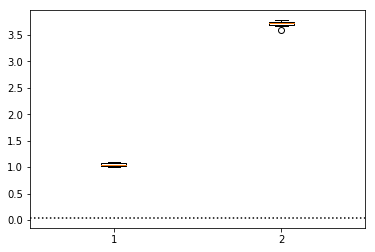

In [74]:
plt.boxplot([t_top15_btm67_means, t_top15_top33_means]);
plt.hlines(0.04, xmin=0.5, xmax=2.5, linestyles='dotted')

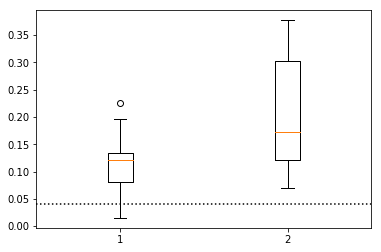

In [77]:
plt.boxplot([v_top15_btm67_means, v_top15_top33_means]);
plt.hlines(0.04, xmin=0.5, xmax=2.5, linestyles='dotted')